<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/numerical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms



drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")



# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/numerical_model.ipynb"
destination_path = "/content/drive/My Drive/numerical_model.ipynb"

  # Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    standardization as standardization,
    data_filter as data_filter,
    add_prev_avg_price as add_prev_avg_price,
    standardization as standardization,




)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
class TransactionDataset(Dataset):

    def __init__(self, X, y):
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.reset_index(drop=True).values.astype('float32')  # Ensure float32 type
        self.y = y.reset_index(drop=True).values.astype('float32')  # Ensure float32 type

    def __len__(self):
        # Return the total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Fetch one sample by index
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test,   batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False)

    return train_loader, test_loader

class FeatureProjection(nn.Module):
    def __init__(self, in_features, output_dim=20):
        super(FeatureProjection, self).__init__()
        self.fc = nn.Linear(in_features, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))


class Numerical_Model(nn.Module):
    def __init__(self, in_features, projection_output_dim=20):
        super(Numerical_Model, self).__init__()

        # Feature Projection to reduce dimensionality
        self.feature_projection = FeatureProjection(in_features, projection_output_dim)

        # The rest of the model architecture after the projection
        self.fc1 = nn.Linear(projection_output_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply feature projection first to reduce input dimensionality
        x = self.feature_projection(x)

        # Pass through the rest of the network
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # Output layer (no activation for regression)

        return x
"""
class Numerical_Model(nn.Module):
    def __init__(self, in_features):
        super(Numerical_Model, self).__init__()
        self.fc1 = nn.Linear(in_features, 128)
        #self.bn1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 64)
        #self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(64, 32)
        #self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(32, 1)

         # Lower dropout
        #self.leaky_relu = nn.LeakyReLU(0.01)  # Leaky ReLU instead of ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation for regression
        return x
"""
def train(network, trainloader, testloader, epochs=30, eta=0.0002):
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=1e-5)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)

    loss = torch.nn.MSELoss()

    val_loss = []

    for epoch in range(epochs):
        # Initialize the total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)
            z = network(x)
            t = t.view(-1, 1)
            J = loss(z, t)
            J_train += J.item() * x.size(0)
            total_train_samples += x.size(0)
            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)
                t = t.view(-1, 1)
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())


    return network, pred, target

Epoch [1/30] Train loss: 11.300839 Test loss: 1.561357
Epoch [2/30] Train loss: 1.557057 Test loss: 1.506948
Epoch [3/30] Train loss: 1.464917 Test loss: 1.369573
Epoch [4/30] Train loss: 1.382410 Test loss: 1.356459
Epoch [5/30] Train loss: 1.322894 Test loss: 1.319678
Epoch [6/30] Train loss: 1.270671 Test loss: 1.322845
Epoch [7/30] Train loss: 1.202703 Test loss: 1.269532
Epoch [8/30] Train loss: 1.148078 Test loss: 1.283958
Epoch [9/30] Train loss: 1.096137 Test loss: 1.209393
Epoch [10/30] Train loss: 1.045676 Test loss: 1.219078
Epoch [11/30] Train loss: 1.018428 Test loss: 1.234692
Epoch [12/30] Train loss: 0.989995 Test loss: 1.201855
Epoch [13/30] Train loss: 0.970153 Test loss: 1.233836
Epoch [14/30] Train loss: 0.958331 Test loss: 1.179880
Epoch [15/30] Train loss: 0.947165 Test loss: 1.157117
Epoch [16/30] Train loss: 0.931933 Test loss: 1.173227
Epoch [17/30] Train loss: 0.927809 Test loss: 1.244121
Epoch [18/30] Train loss: 0.919128 Test loss: 1.149691
Epoch [19/30] Trai

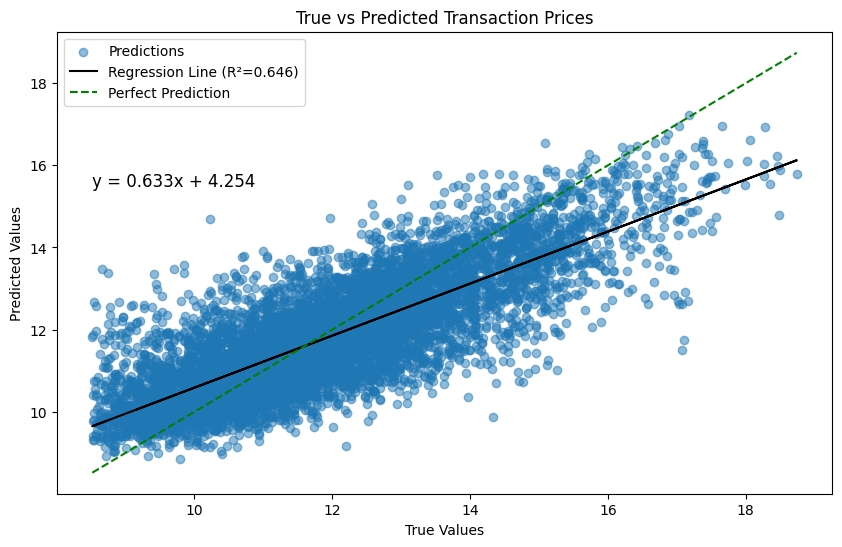

R-squared: 0.527


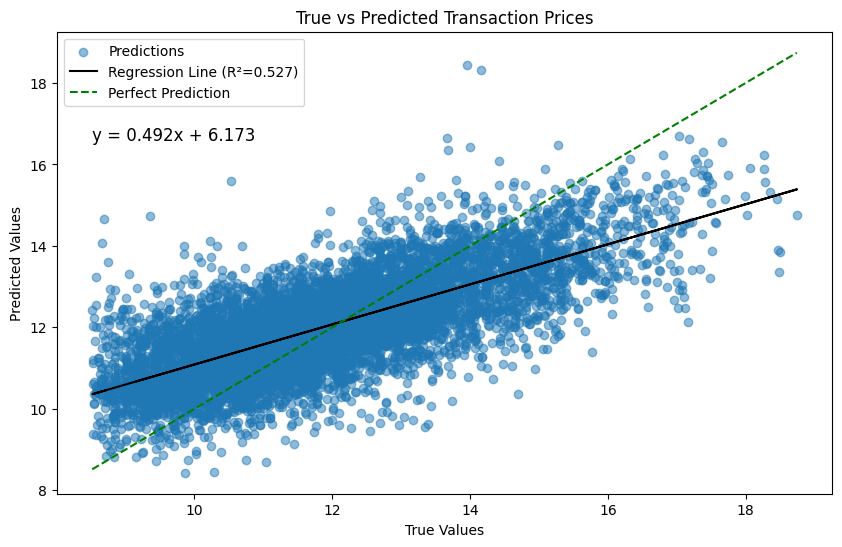

In [51]:
if __name__ == '__main__':
  """
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house', 'transaction_year_semi']
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house']


  X_train, X_test, y_train, y_test = data_split(artwork_numeric_data,
                                                   selected_vars,
                                                   one_hot_vars, 2020,pca = False)




  trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test)
  """

  # Initialize the model with the correct number of input features
  model = Numerical_Model(in_features=X_train.shape[1])


  # Train the model
  NumericalModel, prediction_numerical_model, target = train(model, trainloader,
                                                           testloader,
                                                           epochs = 30)


  # sample checks
  print(f"Total test batches: {len(testloader)}")
  print(f"Total test samples: {len(y_test)}")
  print(f"Test data shape : {X_test.shape}")
  print(f"Train data shape : {X_train.shape}")
  print("Std of y_test:", np.std(y_test))
  print("Std of predictions:", np.std(prediction_numerical_model))



  # Train the model using the training data
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)



  fit_visualization(target, prediction_numerical_model)
  fit_visualization(target, y_pred)




In [46]:
X_train.to_excel("output.xlsx", index=False)